In [1]:
from warnings import filterwarnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
from sklearn.linear_model import LinearRegression

az.style.use("arviz-darkgrid")

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
filterwarnings("ignore")

# A Simple Regression

From [Codes for Unit 1](https://www2.isye.gatech.edu/isye6420/supporting.html).

Associated lecture video: [Unit 1 Lesson 4](https://www.youtube.com/watch?v=c9VXDzJGmNw&list=PLv0FeK5oXK4l-RdT6DWJj0_upJOG2WKNO&index=4)

You don't necessarily need to set inits in PyMC. The default method of generating inits is 'jitter+adapt_diag', which chooses them based on the model and input data while adding some randomness.

If you do want to set an initial value, pass a dictionary to the start parameter of pm.sample.

```python
inits = {
    "alpha": np.array(0.0),
    "beta": np.array(0.0)
}

trace = pm.sample(2000, start=inits)
```


In [3]:
X = np.array([1, 2, 3, 4, 5])
y = np.array([1, 3, 3, 3, 5])
x_bar = np.mean(X)

with pm.Model() as m:
    # priors
    alpha = pm.Normal("alpha", sigma=100)
    beta = pm.Normal("beta", sigma=100)
    # using precision for direct comparison with BUGS output
    tau = pm.Gamma("tau", alpha=0.001, beta=0.001)
    sigma = 1 / pm.math.sqrt(tau)

    mu = alpha + beta * (X - x_bar)
    likelihood = pm.Normal("likelihood", mu=mu, sd=sigma, observed=y)

    # start sampling
    trace = pm.sample(
        3000,  # samples
        chains=4,
        tune=500,
        init="jitter+adapt_diag",
        random_seed=1,
        cores=4,  # parallel processing of chains
        return_inferencedata=True,  # return arviz inferencedata object
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, alpha]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


/Users/aaron/mambaforge/envs/pymc3_test/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/aaron/mambaforge/envs/pymc3_test/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/aaron/mambaforge/envs/pymc3_test/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/aaron/mambaforge/envs/pymc3_test/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 500 tune and 3_000 draw iterations (2_000 + 12_000 draws total) took 10 seconds.
The number of effective samples is smaller than 25% for some parameters.


PyMC3 uses the tuning step specified in the pm.sample call to adjust various parameters in the No-U-Turn Sampler [(NUTS) algorithm](https://arxiv.org/abs/1111.4246), which is a form of Hamiltonian Monte Carlo. BUGS also silently uses different types of tuning depending on the algorithm it [chooses](https://www.york.ac.uk/depts/maths/histstat/pml1/bayes/winbugsinfo/cowles_winbugs.pdf). The professor often burns some number of samples in his examples. Note that this is separate from the tuning phase for both programs!

For some more detail on tuning, see [this post](https://colcarroll.github.io/hmc_tuning_talk/).

In [4]:
# this burns the first 500 samples
trace_burned = trace.sel(draw=slice(500, None))

Arviz has a variety of functions to view the results of the model. One of the most useful is az.summary. Professor Vidakovic arbitrarily asks for the 95% credible set (also called the highest density interval), so we can specify hdi_prob=.95 to get that. This is the HPD, or minimum-width, credible set.

In [5]:
az.summary(trace_burned, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,3.003,0.546,2.004,4.116,0.010,0.007,4288.0,3096.0,1.0
beta,0.799,0.431,0.017,1.616,0.008,0.006,4422.0,2664.0,1.0
tau,1.907,1.562,0.003,5.015,0.031,0.022,2106.0,2440.0,1.0


You can also get the HDIs directly:

In [6]:
az.hdi(trace_burned, hdi_prob=0.95)["beta"].values

array([0.01692589, 1.6158758 ])

There are a variety of plots available. Commonly used to diagnose problems are the trace (see [When Traceplots go Bad](https://jpreszler.rbind.io/post/2019-09-28-bad-traceplots/)) and rank plots (see the Maybe it's time to let traceplots die section from [this post](https://statmodeling.stat.columbia.edu/2019/03/19/maybe-its-time-to-let-the-old-ways-die-or-we-broke-r-hat-so-now-we-have-to-fix-it/)).

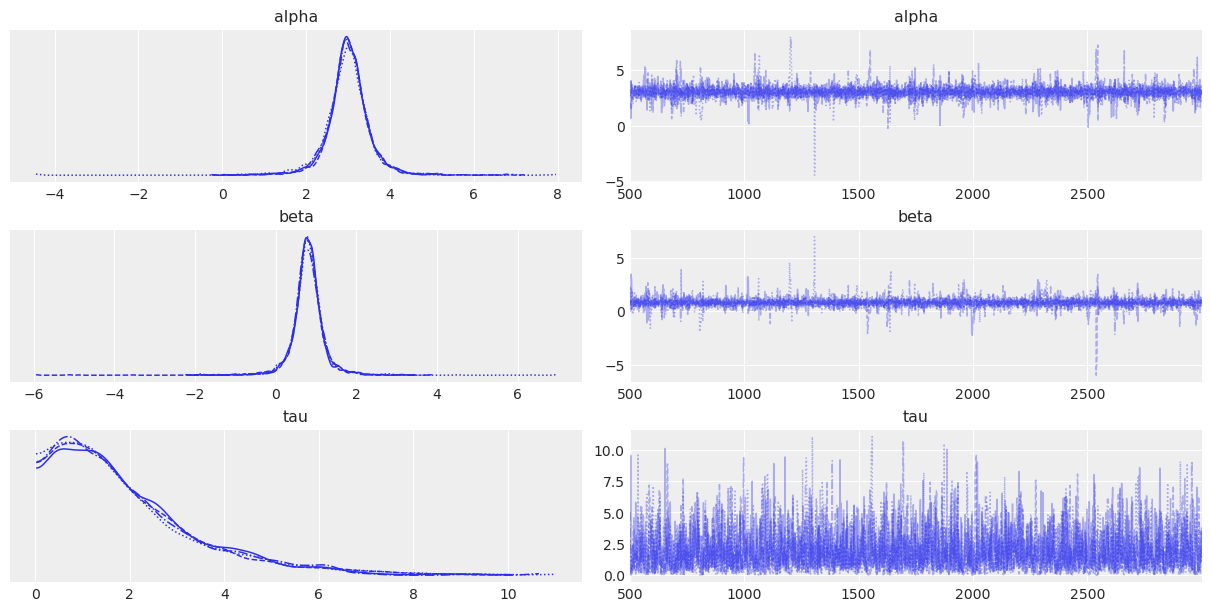

In [7]:
az.plot_trace(trace_burned)
plt.show()

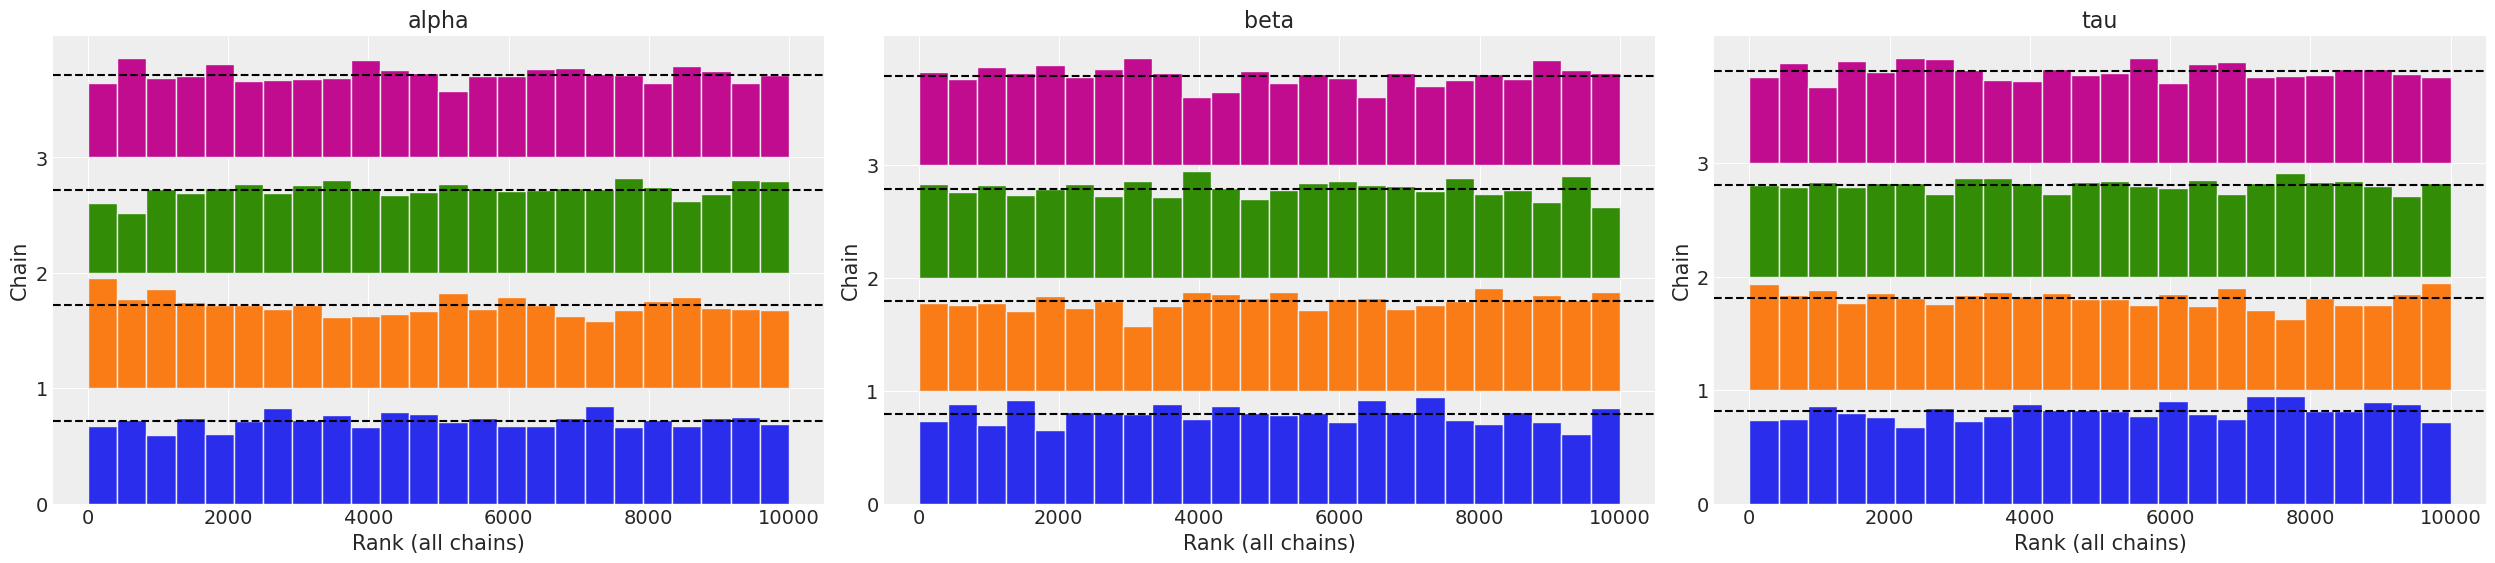

In [8]:
az.plot_rank(trace_burned)
plt.show()

There are many ways to manipulate Arviz [InferenceData](https://arviz-devs.github.io/arviz/api/generated/arviz.InferenceData.html) objects to calculate statistics after sampling is complete.

In [9]:
# alpha - beta * x.bar
intercept = (
    trace_burned.posterior.alpha.mean() - trace_burned.posterior.beta.mean() * x_bar
)
intercept.values

array(0.60513275)

OpenBugs results:

|       | mean   | sd     | MC_error | val2.5pc | median | val97.5pc | start | sample |
|-------|--------|--------|----------|----------|--------|-----------|-------|--------|
| alpha | 2.995  | 0.5388 | 0.005863 | 1.947    | 3.008  | 4.015     | 1000  | 9001   |
| beta  | 0.7963 | 0.3669 | 0.003795 | 0.08055  | 0.7936 | 1.526     | 1000  | 9001   |
| tau   | 1.88   | 1.524  | 0.02414  | 0.1416   | 1.484  | 5.79      | 1000  | 9001   |


Sometimes you might want to do a sanity check with classical regression. If your Bayesian regression has noninformative priors, the results should be close.

In [10]:
reg = LinearRegression().fit(X.reshape(-1, 1), y)
# compare with intercept and beta from above
reg.intercept_, reg.coef_

(0.5999999999999996, array([0.8]))